In [1]:
import pickle
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
# ------------------------------------------------
# 1. Helper Functions for Data Loading
# ------------------------------------------------
def load_pickle_file(file_path):
    """
    Loads a pickle file.
    Args:
        file_path (str): Path to the pickle file.
    Returns:
        Object stored in the pickle.
    """
    with open(file_path, 'rb') as file:
        data = pickle.load(file, encoding='latin1')
    return data

def load_sign_names(csv_path):
    """
    Loads sign names from a CSV file and creates a mapping dictionary.
    Assumes the CSV has columns 'ClassId' and 'SignName'.

    Args:
        csv_path (str): Path to the CSV file.
    Returns:
        dict: Mapping from class ID to sign name.
    """
    df = pd.read_csv(csv_path)
    sign_mapping = dict(zip(df['ClassId'], df['SignName']))
    return sign_mapping

In [4]:
# ------------------------------------------------
# 2. Load the Sign Names Mapping
# ------------------------------------------------
sign_mapping = load_sign_names('C:/Users/ahpuh/Desktop/CNN_Traffic_Sign/signname.csv')
print("Sign Names Mapping:")
for cid, name in sign_mapping.items():
    print(f"Class {cid}: {name}")

Sign Names Mapping:
Class 0: Speed limit (20km/h)
Class 1: Speed limit (30km/h)
Class 2: Speed limit (50km/h)
Class 3: Speed limit (60km/h)
Class 4: Speed limit (70km/h)
Class 5: Speed limit (80km/h)
Class 6: End of speed limit (80km/h)
Class 7: Speed limit (100km/h)
Class 8: Speed limit (120km/h)
Class 9: No passing
Class 10: No passing for vehicles over 3.5 metric tons
Class 11: Right-of-way at the next intersection
Class 12: Priority road
Class 13: Yield
Class 14: Stop
Class 15: No vehicles
Class 16: Vehicles over 3.5 metric tons prohibited
Class 17: No entry
Class 18: General caution
Class 19: Dangerous curve to the left
Class 20: Dangerous curve to the right
Class 21: Double curve
Class 22: Bumpy road
Class 23: Slippery road
Class 24: Road narrows on the right
Class 25: Road work
Class 26: Traffic signals
Class 27: Pedestrians
Class 28: Children crossing
Class 29: Bicycles crossing
Class 30: Beware of ice/snow
Class 31: Wild animals crossing
Class 32: End of all speed and passing 

In [5]:
# 3. Load the Datasets from Pickle Files
# ------------------------------------------------
train_data = load_pickle_file('C:/Users/ahpuh/Desktop/CNN_Traffic_Sign/train.p')
valid_data = load_pickle_file('C:/Users/ahpuh/Desktop/CNN_Traffic_Sign/valid.p')
test_data  = load_pickle_file('C:/Users/ahpuh/Desktop/CNN_Traffic_Sign/test.p')

# Extract features and labels
X_train, y_train = train_data['features'], train_data['labels']
X_valid, y_valid = valid_data['features'], valid_data['labels']
X_test,  y_test  = test_data['features'],  test_data['labels']

print("\nDataset Shapes:")
print(f"Train: features {np.array(X_train).shape}, labels {np.array(y_train).shape}")
print(f"Validation: features {np.array(X_valid).shape}, labels {np.array(y_valid).shape}")
print(f"Test: features {np.array(X_test).shape}, labels {np.array(y_test).shape}")


Dataset Shapes:
Train: features (34799, 32, 32, 3), labels (34799,)
Validation: features (4410, 32, 32, 3), labels (4410,)
Test: features (12630, 32, 32, 3), labels (12630,)


In [6]:
# ------------------------------------------------
# 4. Preprocess the Images
# ------------------------------------------------
def preprocess_images(images, to_gray=True, binarize=True, threshold=128):
    """
    Converts images to grayscale (if needed), flattens them, and binarizes pixel values.

    Args:
        images (list or np.array): List/array of images.
        to_gray (bool): Convert color images to grayscale if True.
        binarize (bool): Convert pixel values to binary.
        threshold (int): Threshold for binarization.

    Returns:
        np.array: Array of processed images.
    """
    processed = []
    for img in images:
        # If image is in color (3 channels) and to_gray is True, convert it.
        if to_gray and len(img.shape) == 3 and img.shape[-1] == 3:
            # OpenCV assumes images are in BGR, but sometimes data is in RGB.
            # You might need to adjust if necessary.
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # Flatten the image to a 1D array.
        img_flat = img.flatten()
        if binarize:
            # Binarize the pixel values (assumes pixel values are in [0, 255])
            img_flat = (img_flat > threshold).astype(np.uint8)
        processed.append(img_flat)
    return np.array(processed)

X_train_proc = preprocess_images(X_train)
X_valid_proc = preprocess_images(X_valid)
X_test_proc  = preprocess_images(X_test)

print("\nProcessed Data Shapes:")
print("Train:", X_train_proc.shape)
print("Validation:", X_valid_proc.shape)
print("Test:", X_test_proc.shape)


Processed Data Shapes:
Train: (34799, 1024)
Validation: (4410, 1024)
Test: (12630, 1024)


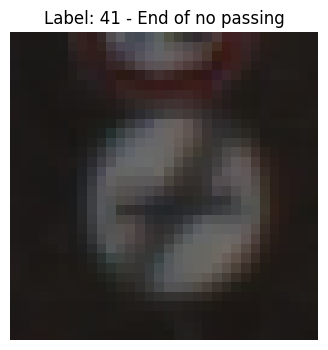

In [7]:
# ------------------------------------------------
# 5. (Optional) Visualize a Sample Image
# ------------------------------------------------
sample_idx = 0  # Change index to inspect other samples
sample_img = X_train[sample_idx]
sample_label = y_train[sample_idx]
plt.figure(figsize=(4, 4))
if len(sample_img.shape) == 2:
    plt.imshow(sample_img, cmap='gray')
else:
    plt.imshow(sample_img)
plt.title(f"Label: {sample_label} - {sign_mapping.get(sample_label, 'Unknown')}")
plt.axis('off')
plt.show()

In [8]:
# Import necessary libraries
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input
import numpy as np

# Normalize images for CNN (pixel values from [0, 255] to [0, 1])
X_train_norm = X_train.astype('float32') / 255.0
X_valid_norm = X_valid.astype('float32') / 255.0
X_test_norm = X_test.astype('float32') / 255.0

# Define CNN architecture for classification
input_layer = Input(shape=(32, 32, 3))  # Input shape matches traffic sign images (32x32x3)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
output_layer = Dense(43, activation='softmax')(x)  # 43 classes for traffic signs

# Create and compile the CNN model
cnn_model = Model(inputs=input_layer, outputs=output_layer)
cnn_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

# Train the CNN on the normalized images
print("\nTraining CNN for traffic sign recognition...")
cnn_model.fit(X_train_norm, y_train,
              validation_data=(X_valid_norm, y_valid),
              epochs=20,
              batch_size=128,
              verbose=1)

# Predict on the test set
test_prob = cnn_model.predict(X_test_norm)
test_pred = np.argmax(test_prob, axis=1)

# Compute test accuracy
test_acc = np.mean(test_pred == y_test) * 100
print(f"\nFinal Test Accuracy: {test_acc:.2f}%")

# Optional: Save predictions for visualization
np.save('test_predictions.npy', test_pred)


Training CNN for traffic sign recognition...
Epoch 1/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - accuracy: 0.2915 - loss: 2.6383 - val_accuracy: 0.6413 - val_loss: 1.1959
Epoch 2/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.8614 - loss: 0.4596 - val_accuracy: 0.8295 - val_loss: 0.6551
Epoch 3/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.9651 - loss: 0.1303 - val_accuracy: 0.8590 - val_loss: 0.6575
Epoch 4/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.9826 - loss: 0.0653 - val_accuracy: 0.8748 - val_loss: 0.6008
Epoch 5/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.9901 - loss: 0.0409 - val_accuracy: 0.8732 - val_loss: 0.6414
Epoch 6/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.9894 - loss: 0.0361 - val_accuracy: 0.8735 - val_loss: 0.7576
Epoch 7/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.9948 - loss: 0.0229 - val_accuracy: 0.8986 - val_loss: 0.5687
Epoch 8/20
272/272 ━━━━━━━━━━━━━━━━━━━━ 10s 

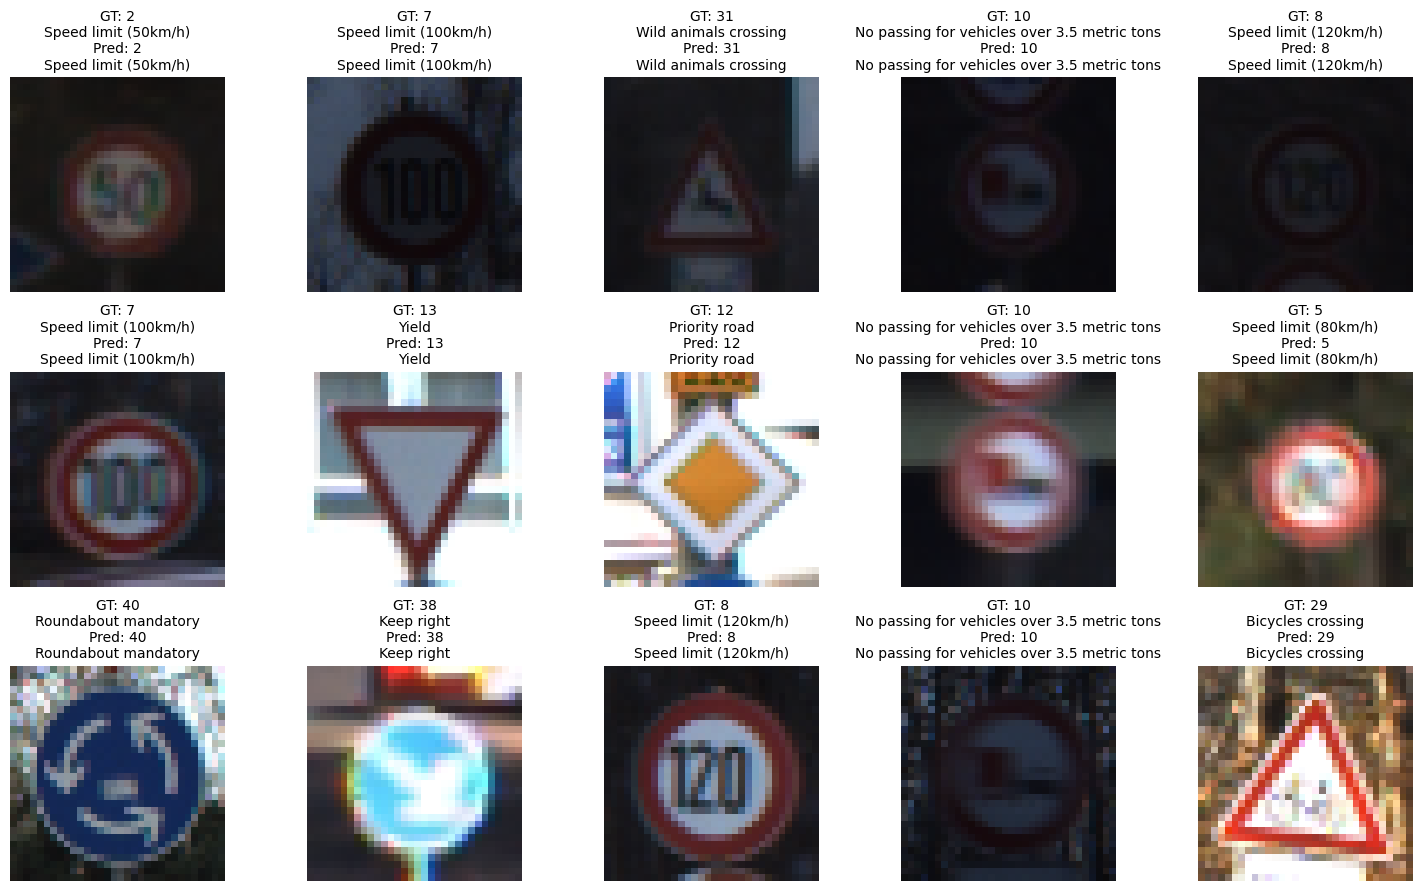

In [9]:
# Select 15 random test samples
num_samples_to_show = 15
indices = np.random.choice(len(X_test), size=num_samples_to_show, replace=False)

# Create a figure with 3 rows and 5 columns
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 9))
axes = axes.flatten()  # Flatten for easy iteration

for ax, idx in zip(axes, indices):
    img = X_test[idx]         # Original image for display
    true_label = y_test[idx]
    pred_label = test_pred[idx]

    # Retrieve the actual sign names using the mapping
    true_sign_name = sign_mapping.get(true_label, 'Unknown')
    pred_sign_name = sign_mapping.get(pred_label, 'Unknown')

    # Display the image
    if len(img.shape) == 2:
        ax.imshow(img, cmap='gray')
    else:
        ax.imshow(img)

    ax.set_title(f"GT: {true_label}\n{true_sign_name}\nPred: {pred_label}\n{pred_sign_name}", fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.show()